In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
#IMPORTANT : these data sets has been resolved from kagle website
DATA_SOURCE_MAPPING = 'bitcoin-price-history:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1896348%2F3105569%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T061751Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ffa89cb2857752c68a3f64499d4e2c05c8db45fbb20b4482d06842835aad45bdaa74b4511fe3cd41a8329595d08760c8bbf82d157fc1eb61163e91bc9480610d92bafdb72ae823644ed8b46c0f19790ff6929585b2c13f8d2f599fcd002b487d662acfd5bc1a4cd58c68b619a442321c68f3c6845ffb314772c3ba264fbd833b891ddd8e71dd318742e78d92d95c05035aacaeae73dbc0aaebebd1b4e764e273ee0b46d0fe493440a5cda03575a061ab6db9882e0acd48efa23ed49ab3f3adb3e783ff3199c35c05490f97dd374b78c003f569d74f606a9f7e95a34883b3486a254eef5c38002edbf5533ae685bd92cf337d2be72f3dee5ac211c6fc9fc9cdd,bitcoin-tweets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1155801%2F5141688%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T061751Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D327a92a84b2caf52abda9218f5ec09f1675735b3594a695e45a0af618b0d9610b7461ff3112f0797249f45de88fb31d7490d86c035484b373e898f51d8420782eecc5caa6eaaa407c26d5b3043eecb45bcafca05b89a30289ab66e9cb2016c2721b4ea36b58ec86631d935c0b4e93ac575f58b35beb9cfd9c29d6bc67957dd292e8a6d2b04e2d2e614f08c66f33f4ce5b368d155f767afbdee02b67775e69b97793a20a9c3f93a7b717ac9917ecb84fb3b1ac2af8b57608a63804d7a0523cc2969bb2bcd3db0777554bc4b2b598dd20fbe5d00b085234f0db2256af30e543f940ae2857d4b69b2d2c6b78b9afa11da392c2244daa6430deac44f3cdaada15f54'

KAGGLE_INPUT_PATH='/data_science/input'
KAGGLE_WORKING_PATH='/data_science/working'
KAGGLE_SYMLINK='data_science'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/data_science/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 77096 bytes downloaded
Downloaded and uncompressed: bitcoin-price-history
[==================================================] 728456658 bytes downloaded
Downloaded and uncompressed: bitcoin-tweets
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
#check if we have got three files here
import os
for dirname, _, filenames in os.walk('/data_science/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/data_science/input/bitcoin-tweets/Bitcoin_tweets.csv
/data_science/input/bitcoin-tweets/Bitcoin_tweets_dataset_2.csv
/data_science/input/bitcoin-price-history/BTC-USD.csv


In [ ]:
! pip install vaderSentiment pandas_datareader textblob

In [ ]:
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from sklearn import preprocessing
import matplotlib.pyplot as plt
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
tweets_raw_file   = '/data_science/input/bitcoin-tweets/Bitcoin_tweets.csv'
tweets_clean_file = './Bitcoin_tweets_clean.csv'
bit_price_file2 = '/data_science/input/bitcoin-price-history/BTC-USD.csv'

In [ ]:
chunk_size = 10**6

chunk_list = []

for chunk in pd.read_csv(tweets_raw_file, chunksize=chunk_size, engine='python', on_bad_lines='skip'):
    # Perform any processing on the chunk
    chunk_list.append(chunk)

# Concatenate all chunks into a single DataFrame if needed
df_raw = pd.concat(chunk_list)



print(df_raw.shape)
df_raw.head(5)

(4693091, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [ ]:
# clean df
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

100%|██████████| 46931/46931 [02:25<00:00, 322.78it/s]


In [ ]:
df_clean = pd.read_csv(tweets_clean_file)

In [ ]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_clean['text'],position=0, leave=True)):
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(30)

100%|██████████| 46931/46931 [00:09<00:00, 5153.44it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,3885516,Crypto Alerted,USA,Crypto Alerted Our Tweets are not Financial Ad...,2020-04-10 11:35:27,608.0,92.0,9.0,False,2022-07-15 13:47:46,Aeron (ARNX) went up 11.6 percent in the last ...,"['ARNX', 'crypto', 'bitcoin', 'cryptocurrency'...",Microsoft Power Platform,False,0.0000
1,984434,☠ Moonpirate Mate ☠,The Open Sea,☠ Moonpirate Crew Member\n☠ Moonpirate Hodler,2021-06-14 03:40:30,48.0,61.0,808.0,False,2021-08-16 05:15:11,Bitcoin looking bullish👍\n\nA Golden Cross on ...,"['Bitcoin', 'BNB', 'Crypto', 'BULLISH']",Twitter Web App,False,0.7297
2,207647,XRP-Phoenix,NaN,NaN,2020-09-02 21:33:04,65.0,173.0,1048.0,False,2021-06-21 21:42:06,I have made 23X gain from doge. Now how many X...,['Bitcoin'],Twitter Web App,False,0.5267
3,2529662,Job Preference,NaN,You Don't Need a middleman to find a decent #J...,2020-11-28 15:56:01,1301.0,604.0,9888.0,False,2022-03-16 16:05:00,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,"['JOB', 'Java', 'Programming', 'Coding', '100D...",Twitter Web App,False,0.2732
4,552292,EdenCrypto,NaN,Cryptoqurency🚀,2021-03-05 08:29:20,67.0,349.0,503.0,False,2021-07-18 14:28:49,This is definitely going to be HUGE! as the t...,"['Airdrops', 'Bitcoin', 'Crypto', 'DeflectProt...",Twitter for Android,False,0.9220
5,3345460,Gifxprimetechnologies,"Business Bay, Dubai, UAE",Forex Broker\nLearn|Trade|Earn\nStart Your Tra...,2021-05-27 06:53:02,6.0,1.0,1.0,False,2022-05-24 13:46:04,START YOUR TRADE WITH GIFXPRIME AND SEE HOW TH...,"['forex', 'bitcoin', 'cryptocurrency', 'financ...",Twitter Web App,False,0.7761
6,2186639,Samsul alam tara,Bangladesh,"Hello every body, this is a samsul alam. I'm a...",2021-04-20 19:21:58,46.0,1570.0,2274.0,False,2022-01-22 12:09:28,\nGood luck team! I believe this is a faithful...,"['Airdrops', 'BSC', 'BNB', 'NFT', 'BTC', 'ETH'...",Twitter for Android,False,0.9701
7,3523978,Kelvin Lee,Singapore,#BTC #CRO,2010-04-16 09:03:17,150.0,1015.0,1087,False,2022-05-31 01:46:25,I am claiming my free Lightning sats from 's z...,"['Bitcoin', 'BTC', 'LN', 'LightningNetwork', '...",Twitter for iPhone,False,0.5562
8,3922994,Alchemist Breuu 🍊💊 🍯🦡,"California, USA",remain curious. Walking out to the Edge. And f...,2020-03-17 03:29:43,1971.0,4800.0,20869.0,False,2022-07-13 23:52:11,When it comes to Bitcoin: /RHrdDa3equ,['Bitcoin'],Twitter for iPhone,False,0.0000
9,2385940,Crypto Leaker,NaN,ATTENTION!!\nEntering any Signal is in your ow...,2022-03-03 06:13:18,62.0,2.0,4.0,False,2022-03-09 19:04:52,Free\n\nFutures_signal\n\n🟢 Long\n\nBAL/USDT\n...,"['Free', 'Futures_signal', 'BAL', 'BTC', 'Bitc...",Twitter for Android,False,-0.0258


In [ ]:
scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
df_clean["score"] = scores
df_clean.head(20)

100%|██████████| 46931/46931 [00:03<00:00, 13243.74it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,3885516,Crypto Alerted,USA,Crypto Alerted Our Tweets are not Financial Ad...,2020-04-10 11:35:27,608.0,92.0,9.0,False,2022-07-15 13:47:46,Aeron (ARNX) went up 11.6 percent in the last ...,"['ARNX', 'crypto', 'bitcoin', 'cryptocurrency'...",Microsoft Power Platform,False,0.0000,NaN
1,984434,☠ Moonpirate Mate ☠,The Open Sea,☠ Moonpirate Crew Member\n☠ Moonpirate Hodler,2021-06-14 03:40:30,48.0,61.0,808.0,False,2021-08-16 05:15:11,Bitcoin looking bullish👍\n\nA Golden Cross on ...,"['Bitcoin', 'BNB', 'Crypto', 'BULLISH']",Twitter Web App,False,0.7297,NaN
2,207647,XRP-Phoenix,NaN,NaN,2020-09-02 21:33:04,65.0,173.0,1048.0,False,2021-06-21 21:42:06,I have made 23X gain from doge. Now how many X...,['Bitcoin'],Twitter Web App,False,0.5267,NaN
3,2529662,Job Preference,NaN,You Don't Need a middleman to find a decent #J...,2020-11-28 15:56:01,1301.0,604.0,9888.0,False,2022-03-16 16:05:00,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,"['JOB', 'Java', 'Programming', 'Coding', '100D...",Twitter Web App,False,0.2732,NaN
4,552292,EdenCrypto,NaN,Cryptoqurency🚀,2021-03-05 08:29:20,67.0,349.0,503.0,False,2021-07-18 14:28:49,This is definitely going to be HUGE! as the t...,"['Airdrops', 'Bitcoin', 'Crypto', 'DeflectProt...",Twitter for Android,False,0.9220,NaN
5,3345460,Gifxprimetechnologies,"Business Bay, Dubai, UAE",Forex Broker\nLearn|Trade|Earn\nStart Your Tra...,2021-05-27 06:53:02,6.0,1.0,1.0,False,2022-05-24 13:46:04,START YOUR TRADE WITH GIFXPRIME AND SEE HOW TH...,"['forex', 'bitcoin', 'cryptocurrency', 'financ...",Twitter Web App,False,0.7761,NaN
6,2186639,Samsul alam tara,Bangladesh,"Hello every body, this is a samsul alam. I'm a...",2021-04-20 19:21:58,46.0,1570.0,2274.0,False,2022-01-22 12:09:28,\nGood luck team! I believe this is a faithful...,"['Airdrops', 'BSC', 'BNB', 'NFT', 'BTC', 'ETH'...",Twitter for Android,False,0.9701,NaN
7,3523978,Kelvin Lee,Singapore,#BTC #CRO,2010-04-16 09:03:17,150.0,1015.0,1087,False,2022-05-31 01:46:25,I am claiming my free Lightning sats from 's z...,"['Bitcoin', 'BTC', 'LN', 'LightningNetwork', '...",Twitter for iPhone,False,0.5562,601.138013
8,3922994,Alchemist Breuu 🍊💊 🍯🦡,"California, USA",remain curious. Walking out to the Edge. And f...,2020-03-17 03:29:43,1971.0,4800.0,20869.0,False,2022-07-13 23:52:11,When it comes to Bitcoin: /RHrdDa3equ,['Bitcoin'],Twitter for iPhone,False,0.0000,NaN
9,2385940,Crypto Leaker,NaN,ATTENTION!!\nEntering any Signal is in your ow...,2022-03-03 06:13:18,62.0,2.0,4.0,False,2022-03-09 19:04:52,Free\n\nFutures_signal\n\n🟢 Long\n\nBAL/USDT\n...,"['Free', 'Futures_signal', 'BAL', 'BTC', 'Bitc...",Twitter for Android,False,-0.0258,NaN


## read Bitcoin price

In [ ]:
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


In [ ]:
import pandas as pd

# Sentiment analysis
df_clean = df_clean.drop_duplicates()
tweets = df_clean.copy()

# Convert 'date' column to datetime with timezone awareness
tweets['date'] = pd.to_datetime(tweets['date'], utc=True, errors='coerce')
tweets.index = tweets['date'].dt.tz_localize(None)  # Remove timezone information for resampling



# Resample tweets data to hourly intervals and sum numeric columns
tweets_grouped = tweets.resample('1h').count()

# Assuming 'df_price' is your cryptocurrency price DataFrame
crypto_usd = df_price.copy()

# Convert 'Date' column to datetime (assuming it's in UNIX timestamp format)
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']

# Resample crypto_usd data to daily intervals and calculate mean of 'Close' column
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()



In [ ]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

In [ ]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation.
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']

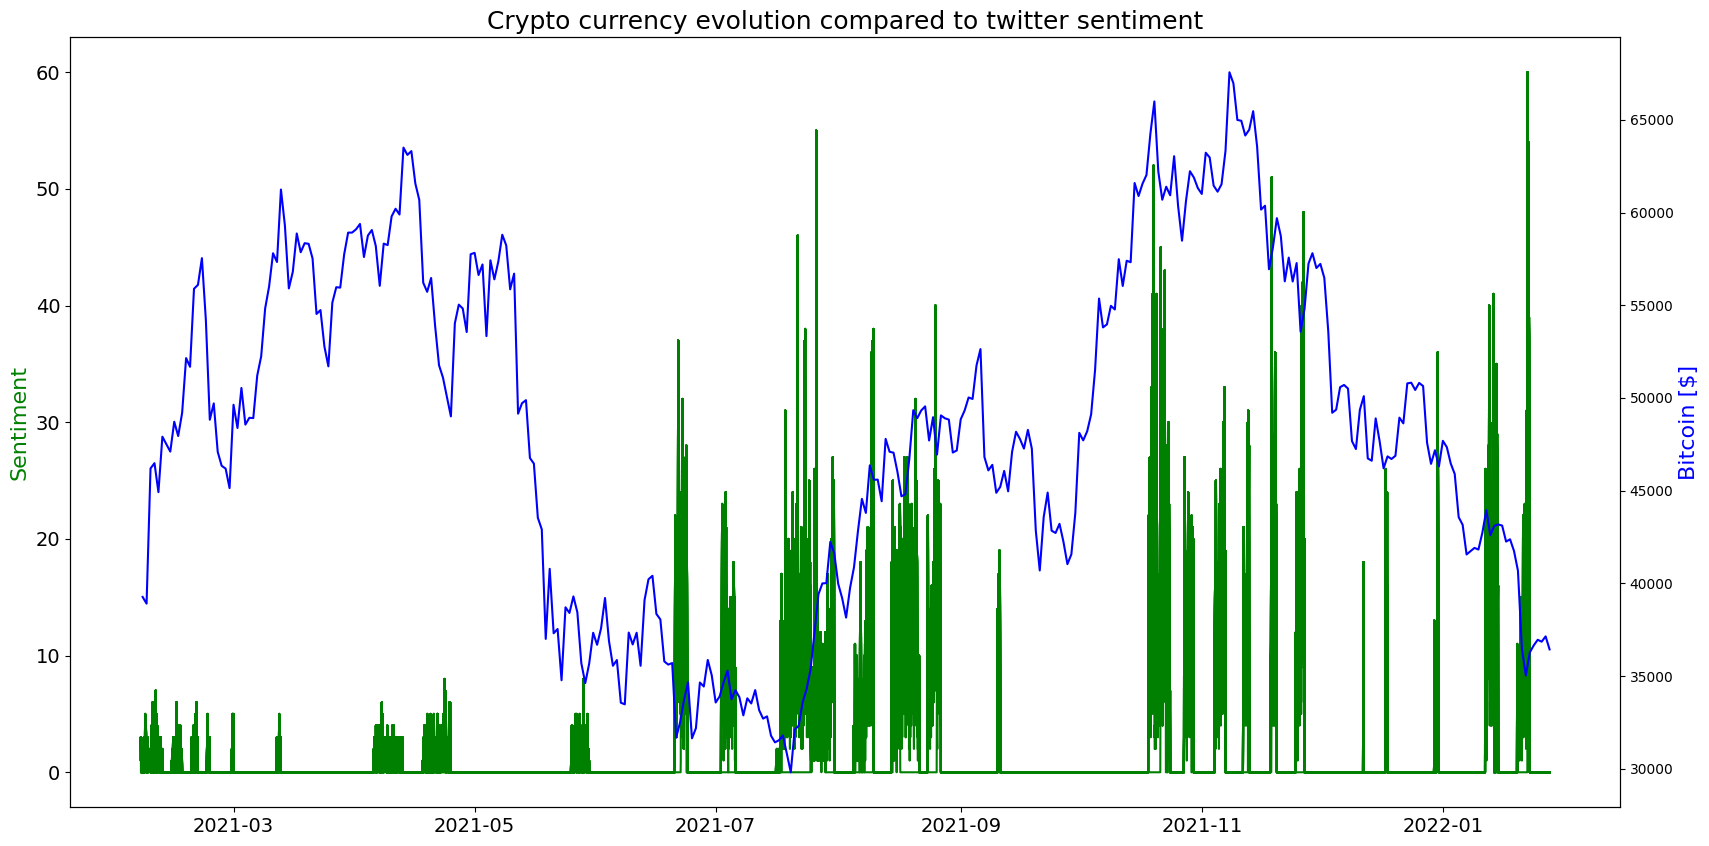

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

## Normalization

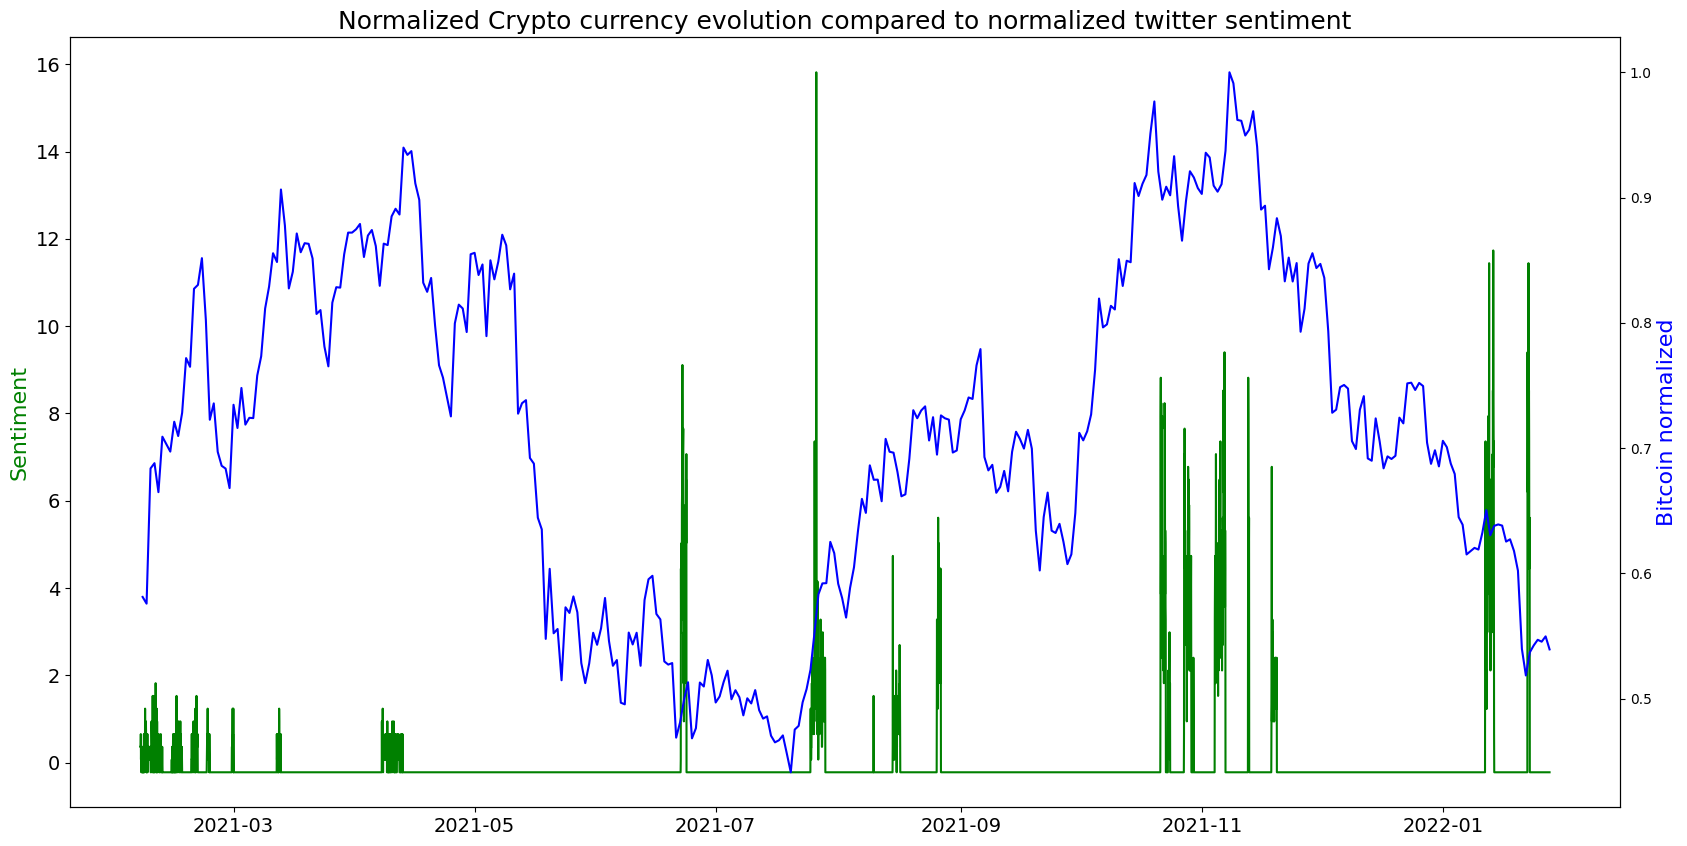

In [ ]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

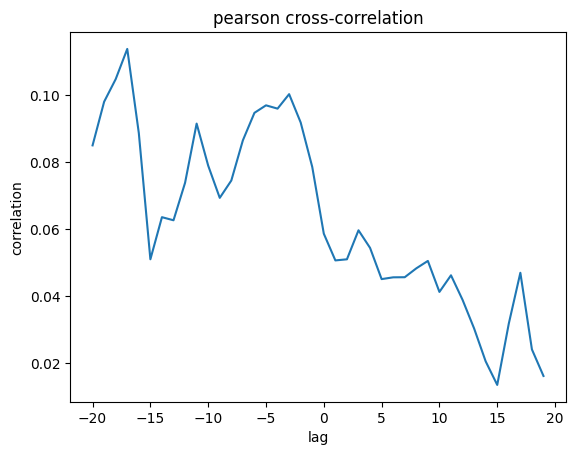

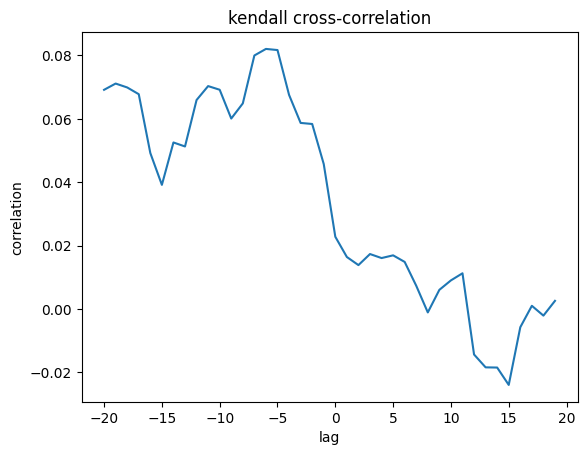

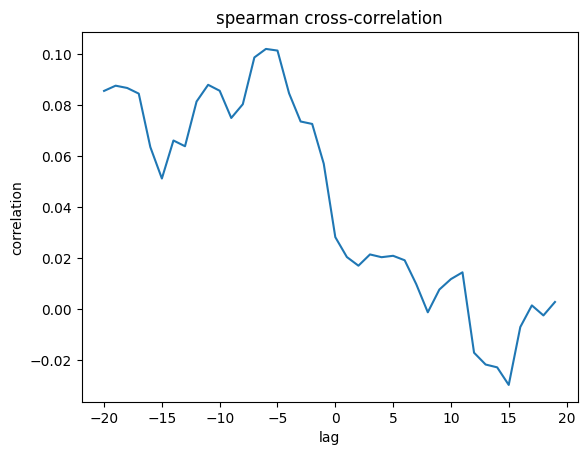

In [ ]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Derivative of Crypto price

In [ ]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

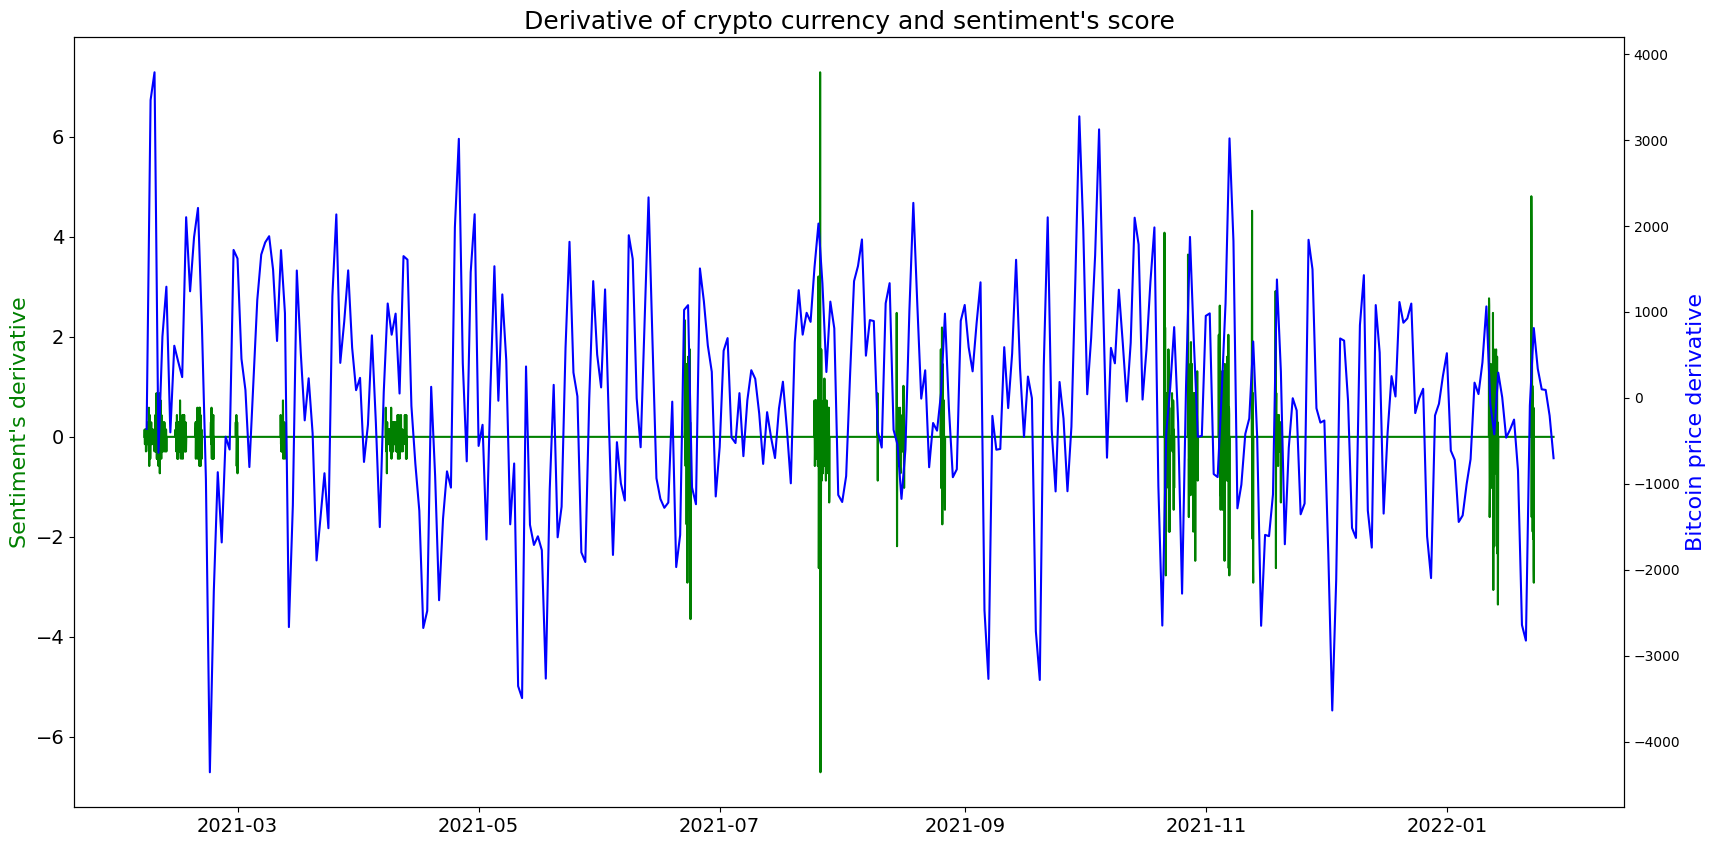

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

In [ ]:
! pip install textblob
from textblob import TextBlob

df = df_clean.copy()
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']]
df.columns = ['tweets']
df.head()

,tweets
0,Aeron (ARNX) went up 11.6 percent in the last ...
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...
2,I have made 23X gain from doge. Now how many X...
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4,This is definitely going to be HUGE! as the t...


In [ ]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [ ]:

def convert_date(date_str):
    try:
        return pd.to_datetime(date_str).strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

df['cleaned_tweets'] = df['tweets'].apply(cleaning)
df['date'] = df_clean['date']
df['date_clean'] = df['date'].apply(convert_date)
df.drop(columns='date',inplace=True)
df.head()

Error occurred: Unknown datetime string format, unable to parse: Editors Against Classifying NFTs As Art🚀#NFT #NFTCommunity #NFTdrop #NFTGiveaway #nftart #Crypto #Bitcoin  #BTC  #Ethereum #ETH #Metaverse, at position 0


,tweets,cleaned_tweets,date_clean
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18


In [ ]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [ ]:
def crypto_price_cate(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'
def observe_period(period):
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    res = res.apply(crypto_price_cate)
    return res

time_sentiment = observe_period(7) # compare price ratio in 7 days. price_7_days_later/ price_now
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [ ]:
# may takes time
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,NaN,0.066667,0.0
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,positive,0.166667,0.1
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,positive,0.500000,0.5
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,NaN,0.800000,0.4
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,positive,0.800000,0.3


In [ ]:
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()
df.to_csv('./df_data.csv')

## Model preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,NaN,0.066667,0.0,neutral,False
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,positive,0.166667,0.1,positive,True
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,positive,0.500000,0.5,positive,True
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,NaN,0.800000,0.4,positive,False
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,positive,0.800000,0.3,positive,True


In [ ]:
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [ ]:
seed = 38 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37357,) (9340,) (37357, 3) (9340, 3)


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(37357, 30) (9340, 30)


Model1

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 100)               5

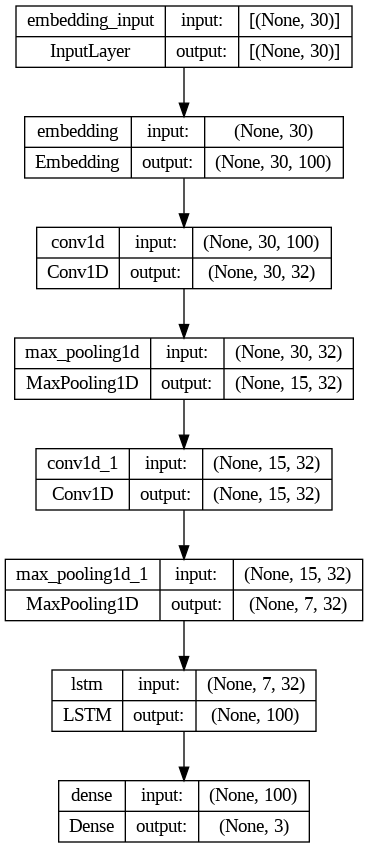

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
292/292 - 39s - loss: 0.4869 - accuracy: 0.8095 - val_loss: 0.1987 - val_accuracy: 0.9406 - 39s/epoch - 134ms/step
Epoch 2/10
292/292 - 18s - loss: 0.1161 - accuracy: 0.9654 - val_loss: 0.1341 - val_accuracy: 0.9575 - 18s/epoch - 62ms/step
Epoch 3/10
292/292 - 20s - loss: 0.0521 - accuracy: 0.9855 - val_loss: 0.1365 - val_accuracy: 0.9591 - 20s/epoch - 67ms/step
Epoch 4/10
292/292 - 23s - loss: 0.0318 - accuracy: 0.9917 - val_loss: 0.1636 - val_accuracy: 0.9577 - 23s/epoch - 77ms/step
Epoch 5/10
292/292 - 19s - loss: 0.0242 - accuracy: 0.9938 - val_loss: 0.1699 - val_accuracy: 0.9610 - 19s/epoch - 66ms/step
Epoch 6/10
292/292 - 18s - loss: 0.0192 - accuracy: 0.9951 - val_loss: 0.1939 - val_accuracy: 0.9571 - 18s/epoch - 63ms/step
Epoch 7/10
292/292 - 18s - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.2356 - val_accuracy: 0.9543 - 18s/epoch - 63ms/step
Epoch 8/10
292/292 - 19s - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.2244 - val_accuracy: 0.9558 - 19s/epoch - 65ms/step

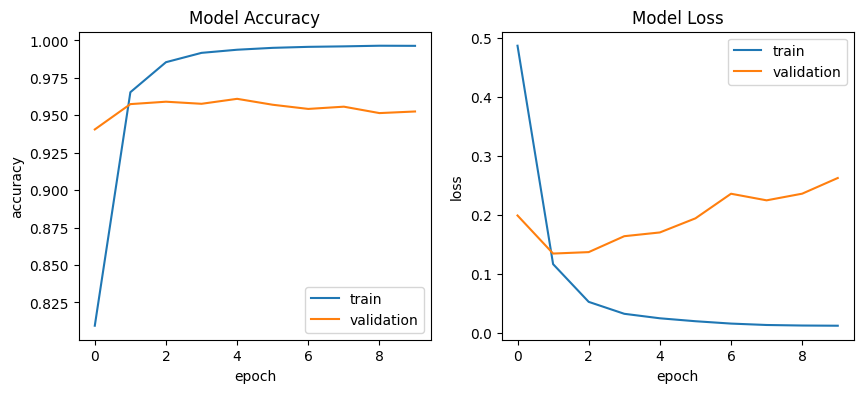

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

In [ ]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

292/292 [==============================] - 2s 5ms/step
Accuracy:	95.3%
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1072
           1       0.97      0.96      0.97      3951
           2       0.94      0.98      0.96      4317

    accuracy                           0.95      9340
   macro avg       0.94      0.91      0.93      9340
weighted avg       0.95      0.95      0.95      9340



## Model2

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

#print('Before Tokenization & Padding \n', df['cleaned_tweets'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaned_tweets'])
print('After Tokenization & Padding \n', X[0])

After Tokenization & Padding 
 [ 521  734   23  356 1199    3    1    6    2    9   15    4   31   37
   11   52    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (28017, 50) (28017, 3)
Validation Set:  (9340, 50) (9340, 3)
Test Set:  (9340, 50) (9340, 3)


In [ ]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

In [ ]:
# Define your learning rate schedule
initial_learning_rate = 0.01
decay_steps = 100000
decay_rate = 0.96
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

In [ ]:
#sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule, momentum=0.9, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

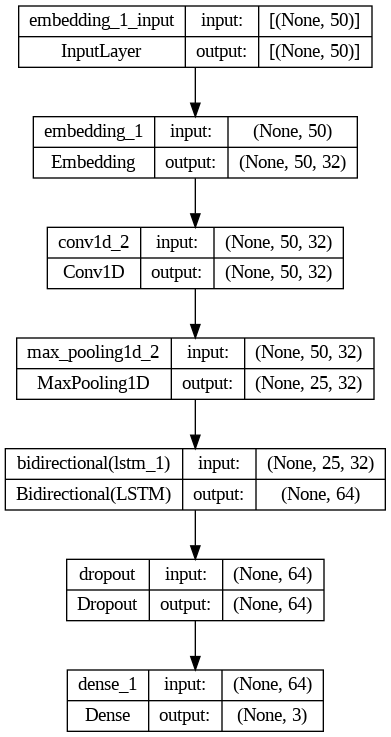

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/50
219/219 [==============================] - 16s 56ms/step - loss: 0.9641 - accuracy: 0.5019 - precision: 0.5835 - recall: 0.1135 - val_loss: 0.9275 - val_accuracy: 0.5924 - val_precision: 0.6377 - val_recall: 0.3784
Epoch 2/50
219/219 [==============================] - 10s 48ms/step - loss: 0.9084 - accuracy: 0.5826 - precision: 0.6215 - recall: 0.4592 - val_loss: 0.8897 - val_accuracy: 0.6012 - val_precision: 0.6284 - val_recall: 0.4985
Epoch 3/50
219/219 [==============================] - 10s 43ms/step - loss: 0.8682 - accuracy: 0.6152 - precision: 0.6551 - recall: 0.5148 - val_loss: 0.8298 - val_accuracy: 0.6394 - val_precision: 0.6776 - val_recall: 0.5612
Epoch 4/50
219/219 [==============================] - 10s 45ms/step - loss: 0.7877 - accuracy: 0.6713 - precision: 0.7171 - recall: 0.5885 - val_loss: 0.7258 - val_accuracy: 0.7035 - val_precision: 0.7454 - val_recall: 0.6528
Epoch 5/50
219/219 [==============================] - 11s 51ms/step - loss: 0.6384 - accuracy: 0

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9437
Precision : 0.9449
Recall    : 0.9425
F1 Score  : 0.9437


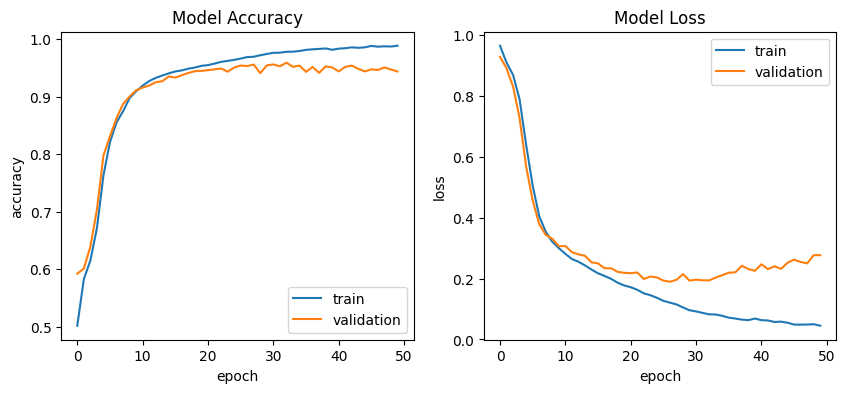

In [ ]:
plot_training_hist(history)